In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import re
import time
%matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import textwrap
import scipy.stats as stats

from scipy import stats
import scipy
from functools import partial

import matplotlib.pylab as pylab
import seaborn as sns
sns.set_style('whitegrid', {'legend.frameon':True})
sns.set_palette(sns.color_palette("Set1", 12))
#sns.set_context("paper")
fontsize = 12
params = {'legend.fontsize': fontsize,
  'figure.figsize': (18, 15),
  'axes.labelsize': fontsize,
  'axes.titlesize':fontsize,
  'axes.edgecolor':"0.3",
  'xtick.labelsize':fontsize,
  'ytick.labelsize':fontsize,
  'legend.fontsize':10,
  'font.size':fontsize,
  'font.family':'serif'}
pylab.rcParams.update(params)
plt.rc('axes', labelsize=fontsize) 

#plt.style.use('ggplot')
%matplotlib inline

from tqdm.notebook import tqdm
import pandas as pd
from pathlib2 import Path
import os

Using matplotlib backend: Qt5Agg


In [2]:
import sys
sys.path.append('../')

from metric_store import save_metrics, save_metric, load_metrics, get_metric_names, load_metric
from network_metrics import prepare_metric
from pipeline.pipeline import load_config

In [26]:
config_name = "pipeline.config"
config = load_config(config_name)

In [133]:
config.download_ERA5_options['work_dir']

WindowsPath('D:/Work/Data/ERA5/ERA5_MSL_1982_2020_3h_0.75')

In [4]:
from corr_network import load_data, get_available_mask
data = load_data(config)
available_mask = get_available_mask(data)

In [5]:
metric_names = ['input_data/MSLP_preproc']
for metric_name in metric_names:
    config.metrics_plot_options['metric_name'] = metric_name
    metric = load_metric(config, metric_name)
    metric = prepare_metric(metric_name, metric, available_mask)
    print(metric_name, metric.shape, config.metric_dimension[metric_name])    

input_data/MSLP_preproc (36, 69, 113960) 2D


In [6]:
prefix = 'network_metrics'
metric_names = list(get_metric_names(config, prefix = prefix).keys())
metric_names

['network_metrics/LCC_w',
 'network_metrics/GCC_w',
 'network_metrics/degree_w',
 'network_metrics/EVC_w',
 'network_metrics/closeness_w',
 'network_metrics/LCC_0.9',
 'network_metrics/GCC_0.9',
 'network_metrics/degree_0.9',
 'network_metrics/EVC_0.9',
 'network_metrics/closeness_0.9',
 'network_metrics/LCC_0.95',
 'network_metrics/GCC_0.95',
 'network_metrics/degree_0.95',
 'network_metrics/EVC_0.95',
 'network_metrics/closeness_0.95']

In [7]:
data = np.load('../cyclones_events.npz')
list(data.keys())
cyclone_events = data['cyclone_events_6']
cyclone_events_1d = cyclone_events.sum(axis=(0, 1))
cyclone_events_1d.shape

(113960,)

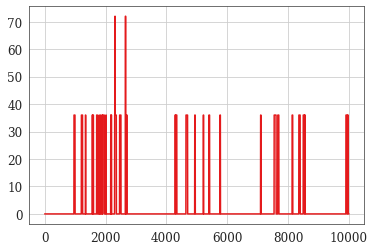

In [16]:
plt.plot(cyclone_events_1d[:10000])
pass

In [39]:
from metric_store import get_metric_names, load_metric, save_metric
from g_test_for_metrics.g_test_for_metrics import get_metric_indicators, get_sign_for_metric
metric_name = 'probability_for_metrics/network_metrics/LCC_w'
main_metric_name = metric_name[metric_name.find("/") + 1:]
metric_prob = load_metric(config, metric_name)
predicted_events = get_metric_indicators(config, main_metric_name, metric_prob, thr=0.05)    


In [40]:
predicted_events_1d_sum = predicted_events.sum(axis=(0, 1))
predicted_events_1d_sum.shape

(113960,)

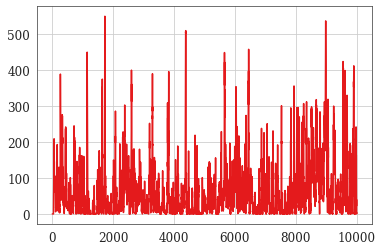

In [22]:
plt.plot(predicted_events_1d_sum[:10000])
pass

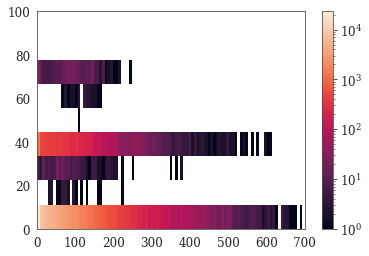

In [32]:
im = plt.hist2d(predicted_events_1d_sum, cyclone_events_1d, bins=(np.linspace(0, 700, 100), np.linspace(0, 100, 10)), norm=matplotlib.colors.LogNorm())
plt.colorbar()
pass

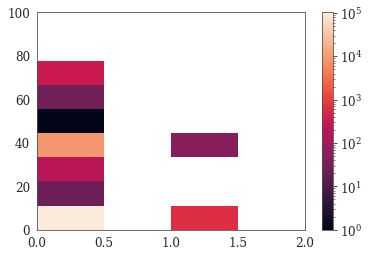

In [35]:
im = plt.hist2d(predicted_events_1d_sum > 400, cyclone_events_1d, bins=(np.linspace(0, 2, 5), np.linspace(0, 100, 10)), norm=matplotlib.colors.LogNorm())
plt.colorbar()
pass

In [39]:
from numba import jit
from helpers import numba_config
from scipy.stats import chi2_contingency
@jit(nopython = numba_config.nopython, nogil = numba_config.nogil, cache = numba_config.cache, error_model="numpy")
def estimate_prediction(predicted_events_1d, cyclone_events_1d, w = 5 * 8):
    cyclone_events_1d_start = np.zeros_like(cyclone_events_1d)
    nt = len(predicted_events_1d)
    blocked = np.zeros_like(predicted_events_1d)
    for i in range(1, nt):
        if cyclone_events_1d[i] > 0:
            if cyclone_events_1d[i - 1] == 0:
                cyclone_events_1d_start[i] = 1
            else:
                blocked[i] = 1
    A = 0
    B = 0
    C = 0
    D = 0
    for i in range(nt):
        if predicted_events_1d[i]:
            if not blocked[i]:
                if np.any(cyclone_events_1d_start[i:i + w]):
                    D += 1
                else:
                    C += 1
                blocked[i:i + w] = 1
        else:
            if not blocked[i]:
                if np.any(cyclone_events_1d_start[i:i + w]):
                    B += 1
                else:
                    A += 1
                
    A //= w
    B //= w

    #print(predicted_events_1d[:100])
    #print(cyclone_events_1d[:100])
    #print(blocked[:100])
    contigency_table = np.array([[A, B], [C, D]])
    return contigency_table

def perform_g_test(contigency_table):
    #print(contigency_table)

    if ((contigency_table[0, 0] == 0) and (contigency_table[0, 1] == 0)) or ((contigency_table[1, 0] == 0) and (contigency_table[1, 1] == 0)):
        I_stat = g_stat = p_val = np.nan
    else:
        g_stat, p_val, dof, expctd = chi2_contingency(contigency_table, lambda_="log-likelihood", correction=False)
        I_stat = g_stat / contigency_table.flatten().sum() / 2
    #print(g_stat, p_val)
    #print(nt / w, A + B + C + D)
    return g_stat, p_val, I_stat

def traverse_g_stat(window_sizes, thr_probs, thrs, metric_prob, main_metric_name, cyclone_events_1d):
    from g_test_for_metrics.g_test_for_metrics import get_metric_indicators, get_sign_for_metric
    g_stat_full = []
    p_vals_full = []
    I_stat_full = []
    for window_size in tqdm(window_sizes):
        g_stats = []
        p_vals = []
        I_stats = []
        for thr_prob in tqdm(thr_probs):
            g_stats += [[]]
            p_vals += [[]]
            I_stats += [[]]
            if get_sign_for_metric(config, main_metric_name) == '>':
                thr_prob = 1 - thr_prob

            predicted_events = get_metric_indicators(config, main_metric_name, metric_prob, thr=thr_prob)
            predicted_events_1d_sum = predicted_events.sum(axis=(0, 1))
            for thr in thrs:
                predicted_events_1d = predicted_events_1d_sum > thr
                contigency_table = estimate_prediction(predicted_events_1d, cyclone_events_1d, window_size)
                g_stat, p_val, I_stat = perform_g_test(contigency_table)
                g_stats[-1] += [g_stat]
                p_vals[-1] += [p_val]
                I_stats[-1] += [I_stat]
        p_vals = np.array(p_vals)
        p_vals_full += [p_vals]

        g_stats = np.array(g_stats)
        g_stat_full += [g_stats]

        I_stats = np.array(I_stats)
        I_stat_full += [I_stats]

    return g_stat_full, p_vals_full, I_stat_full

In [105]:
window_sizes = [1 * 8, 2 * 8, 3 * 8, 4 * 8, 5 * 8]
#thr_probs = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
thr_probs = np.geomspace(1e-5, 1e-1, 33)
thrs = np.linspace(0, 50, 51)
g_stat_full, p_vals_full = traverse_g_stat(window_sizes, thr_probs, thrs, metric_prob, main_metric_name, cyclone_events_1d)
export_g_stat(config, g_stat_full, p_vals_full, thr_probs, thrs)

array([1.00000000e-05, 1.33352143e-05, 1.77827941e-05, 2.37137371e-05,
       3.16227766e-05, 4.21696503e-05, 5.62341325e-05, 7.49894209e-05,
       1.00000000e-04, 1.33352143e-04, 1.77827941e-04, 2.37137371e-04,
       3.16227766e-04, 4.21696503e-04, 5.62341325e-04, 7.49894209e-04,
       1.00000000e-03, 1.33352143e-03, 1.77827941e-03, 2.37137371e-03,
       3.16227766e-03, 4.21696503e-03, 5.62341325e-03, 7.49894209e-03,
       1.00000000e-02, 1.33352143e-02, 1.77827941e-02, 2.37137371e-02,
       3.16227766e-02, 4.21696503e-02, 5.62341325e-02, 7.49894209e-02,
       1.00000000e-01])

In [44]:
def plot_g_stat(g_stats, thr_probs, thrs, clim, title_name, clim_logspace):
    from matplotlib import colors
    fig = plt.figure(figsize=(10, 3), dpi=150)
    if clim_logspace:
        norm = colors.LogNorm()
    else:
        norm = None
    im = plt.imshow(g_stats, aspect='auto', clim=clim, cmap='viridis', norm=norm)
    xticks_ids = np.arange(0, len(thrs), 5)
    ax = plt.gca()
    ax.set_xticks(xticks_ids)
    ax.set_xticklabels(map(lambda x: "{:0.0f}".format(x), thrs[xticks_ids]))
    thr_probs = np.array(thr_probs)
    yticks_ids = np.arange(0, len(thr_probs), 4)
    ax.set_yticks(yticks_ids)
    ax.set_yticklabels(map(lambda x: "{:0.1g}".format(x), thr_probs[yticks_ids]))
    plt.colorbar()
    plt.grid(False)
    plt.title(title_name)
    plt.xlabel('Threshold: number of predicted pixels on frame')
    plt.ylabel('Threshold: CCDF probability')
    return fig

def export_g_stat(config, g_stat_full, p_vals_full, I_stat_full, thr_probs, thrs):
    path_name = config.work_dir
    path_name /= f"results_{config.prefix_for_preproc_data}_{config.prefix_for_corr}"
    path_name /= "cyclone_metric_relation"
    path_name /= f"track_size_{config.g_test_options['track_size']}"
    path_name /= f"{config.g_test_options['metric_name']}"
    path_name.mkdir(parents=True, exist_ok=True)
    max_g_stat = 0
    min_p_vals = 1e9
    max_I_stat = 0
    for i, window_size in tqdm(enumerate(window_sizes)):
        max_g_stat = max(max_g_stat, np.nanmax(g_stat_full[i]))
        min_p_vals = min(min_p_vals, np.nanmin(p_vals_full[i]))
        max_I_stat = max(max_I_stat, np.nanmax(I_stat_full[i]))
    print(max_g_stat, min_p_vals, max_I_stat)
    for i, window_size in tqdm(enumerate(window_sizes)):
        g_stats = g_stat_full[i]
        fig = plot_g_stat(g_stats, thr_probs, thrs, clim = [0, max_g_stat], title_name = f"G-stat. Window block size: {window_size / 8} days", clim_logspace=False)
        file_name = path_name / f"g-stat_window_size_{window_size / 8}.png"
        plt.savefig(file_name, bbox_inches='tight')
        plt.close(fig)

        p_vals = p_vals_full[i]
        fig = plot_g_stat(p_vals, thr_probs, thrs, clim = [min_p_vals, 1], title_name = f"P-value. Window block size: {window_size / 8} days", clim_logspace=True)
        file_name = path_name / f"p-value_window_size_{window_size / 8}.png"
        plt.savefig(file_name, bbox_inches='tight')
        plt.close(fig)

        I_stats = I_stat_full[i]
        fig = plot_g_stat(I_stats, thr_probs, thrs, clim=[1e-4, max_I_stat], title_name = f"Information. Window block size: {window_size / 8} days", clim_logspace=True)
        file_name = path_name / f"Information_window_size_{window_size / 8}.png"
        plt.savefig(file_name, bbox_inches='tight')
        plt.close(fig)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

1 1.0 0.0007498942093324559 69.11138080803818 9.305682049226779e-17 0.00033009208964053196
2 1.0 0.0007498942093324559 69.6557572310256 7.061233160584489e-17 0.0006650476162522256
3 2.0 0.0007498942093324559 65.99484647392244 4.52103553059606e-16 0.000944754007986979
4 2.0 0.0009305720409296989 61.36354812453365 4.745148118324546e-15 0.0011704793065374748
5 0.0 0.00025482967479793463 62.01374540473961 3.410682521924611e-15 0.001478136659311141
6 2.0 0.0009305720409296989 53.6698289570833 2.3717775380745336e-13 0.0015332484560931121
7 2.0 0.0009305720409296989 52.68501194712894 3.9156790740742633e-13 0.001754997066859725
8 0.0 0.00016548170999431815 60.34436955106089 7.963201325191935e-15 0.002298132742442718
9 0.0 0.00016548170999431815 53.59714973103553 2.4611621814884447e-13 0.0022951845551145737
10 1.0 0.0002053525026457146 54.94168849996697 1.2415932643457023e-13 0.0026147767228234804
11 1.0 0.0002053525026457146 50.584143906330326 1.141636647500901e-12 0.0026461678126349824
12 14.

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

1 2.0 0.006493816315762113 152.3435355060476 5.33020866307134e-35 0.0007276282920477986
2 4.0 0.006493816315762113 149.85324402215147 1.8665395532278471e-34 0.0014303614151743073
3 2.0 0.0027384196342643613 150.1668930324524 1.59397320975873e-34 0.0021484947639633218
4 1.0 0.0027384196342643613 142.51431246128246 7.506290933751049e-33 0.0027165245789577686
5 1.0 0.004216965034285823 134.1406732726292 5.089830815055378e-31 0.0031904831431982966
6 1.0 0.004216965034285823 127.6166997949492 1.3615486221458197e-29 0.0036393286886143043
7 2.0 0.0027384196342643613 120.35063504445688 5.301161093407723e-28 0.004004213303315706
8 2.0 0.0027384196342643613 128.58741568457071 8.348801589628267e-30 0.0048855401095961514
9 2.0 0.0027384196342643613 127.90172165829671 1.1794086431690076e-29 0.005461684245379482
10 2.0 0.0022067340690845897 116.29740630397859 4.091069517266165e-27 0.005514338847983811
11 2.0 0.0022067340690845897 105.35215743448413 1.0224904140908998e-24 0.0054888067851664125
12 2.0

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

1 1.0 0.0027384196342643613 112.6416451072562 2.5852028163186626e-26 0.000538002794608856
2 0.0 0.0017782794100389228 129.14152214746375 6.315121249275913e-30 0.0012329958768304125
3 1.0 0.003398208328942559 116.27948347733297 4.128208910535532e-27 0.0016638927862934717
4 0.0 0.003398208328942559 109.76044743556494 1.1057790764085258e-25 0.0020920300277430135
5 1.0 0.0017782794100389228 100.90368461283079 9.656673473661903e-24 0.0024040713955215567
6 1.0 0.003398208328942559 103.87535579489389 2.154527856338729e-24 0.0029654949124955435
7 1.0 0.003398208328942559 100.23165220143622 1.3557545761974756e-23 0.0033352739318992485
8 1.0 0.003398208328942559 94.55963983562813 2.378181407779865e-22 0.003592418502987164
9 1.0 0.003398208328942559 84.79204016101639 3.314560588689067e-20 0.003620187864444385
10 0.0 0.0017782794100389228 78.399798156995 8.416076607852751e-19 0.0037170395485015646
11 1.0 0.003398208328942559 76.12290298043024 2.6654780150407484e-18 0.003963495937750194
12 0.0 0.00

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

1 1.0 0.005232991146814947 150.7790645884778 1.171325501543803e-34 0.0007201560137005197
2 5.0 0.006493816315762113 148.2887525911388 4.1021502676968864e-34 0.0014155092839933066
3 2.0 0.0022067340690845897 149.00401289920296 2.861959568656132e-34 0.002131979008430433
4 4.0 0.003398208328942559 138.5375814692579 5.559330333444766e-32 0.0026407224556680626
5 4.0 0.003398208328942559 130.49235726396472 3.1976102693860026e-30 0.0031060734376836315
6 1.0 0.0022067340690845897 125.13611511514395 4.752069223146177e-29 0.0035706247536136495
7 0.0 0.0011547819846894581 120.99071657991524 3.8392427756834913e-28 0.004025777486521436
8 0.0 0.0011547819846894581 123.55244730094793 1.05558866360817e-28 0.004692815531029623
9 1.0 0.0022067340690845897 120.40887002648068 5.147804745024995e-28 0.0051399671316691145
10 2.0 0.0017782794100389228 114.41371159970302 1.057701133039548e-26 0.005425536399834172
11 2.0 0.0014330125702369627 105.20044799504043 1.103849265232045e-24 0.005483759799574668
12 1.0 

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

1 6.0 0.003398208328942559 112.63438509909523 2.594686361489961e-26 0.0005379681191149411
2 4.0 0.0022067340690845897 95.56804377008667 1.428944948481597e-22 0.0009123963546368925
3 14.0 0.006493816315762113 90.13796935472163 2.2211790227203602e-21 0.001289859611269306
4 8.0 0.003398208328942559 93.39080963002898 4.29239249160641e-22 0.001781179616074706
5 9.0 0.003398208328942559 88.38117724392967 5.398204189603149e-21 0.0021057175556068253
6 17.0 0.006493816315762113 87.74764172071541 7.436153506957258e-21 0.002505500591648547
7 17.0 0.006493816315762113 90.82762314923659 1.5674971755949116e-21 0.0030237573456700375
8 17.0 0.006493816315762113 97.59270327256078 5.139296613853368e-23 0.003709902808201961
9 20.0 0.006493816315762113 83.3545157103479 6.858196313619244e-20 0.003563377039601056
10 17.0 0.006493816315762113 87.67625062620226 7.709454502543256e-21 0.004156060420278833
11 10.0 0.0014330125702369627 76.7752635579474 1.9156201567254053e-18 0.0040200682562544455
12 10.0 0.00143

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

1 0.0 0.005232991146814947 312.3375013233647 6.761169595692157e-70 0.0014917968253492127
2 0.0 0.005232991146814947 342.47489905389165 1.844536628735215e-76 0.003268763591931925
3 0.0 0.004216965034285823 346.5290445709718 2.4154605457940715e-77 0.004957213386515389
4 0.0 0.005232991146814947 326.0129533267944 7.0988374118542e-73 0.006209060932594264
5 1.0 0.006493816315762113 291.86569710376193 1.9500341643263615e-65 0.006940590152757584
6 1.0 0.005232991146814947 261.4628191392887 8.234929325892997e-59 0.007455030198998879
7 1.0 0.005232991146814947 285.22198230292577 5.46603634842094e-64 0.009478332523691539
8 1.0 0.004216965034285823 272.4594001918151 3.302954031061428e-61 0.010347869357835743
9 1.0 0.004216965034285823 268.26605950911886 2.709058945622513e-60 0.011444797760627937
10 0.0 0.003398208328942559 261.35102234982696 8.710205701264515e-59 0.012372231696166776
11 0.0 0.0027384196342643613 248.91766729311192 4.470951693447812e-56 0.012955015472734043
12 0.0 0.00220673406908

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

1 0.0 0.005232991146814947 312.3375013233647 6.761169595692157e-70 0.0014917968253492127
2 0.0 0.005232991146814947 342.47489905389165 1.844536628735215e-76 0.003268763591931925
3 0.0 0.004216965034285823 346.5290445709718 2.4154605457940715e-77 0.004957213386515389
4 0.0 0.005232991146814947 326.0129533267944 7.0988374118542e-73 0.006209060932594264
5 1.0 0.006493816315762113 291.86569710376193 1.9500341643263615e-65 0.006940590152757584
6 1.0 0.005232991146814947 261.4628191392887 8.234929325892997e-59 0.007455030198998879
7 1.0 0.005232991146814947 285.22198230292577 5.46603634842094e-64 0.009478332523691539
8 1.0 0.004216965034285823 272.4594001918151 3.302954031061428e-61 0.010347869357835743
9 1.0 0.004216965034285823 268.26605950911886 2.709058945622513e-60 0.011444797760627937
10 0.0 0.003398208328942559 261.35102234982696 8.710205701264515e-59 0.012372231696166776
11 0.0 0.0027384196342643613 248.91766729311192 4.470951693447812e-56 0.012955015472734043
12 0.0 0.00220673406908

C:\Users\MIKE_L~1\AppData\Local\Temp/ipykernel_20672/2110466431.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5, 3), dpi=150)


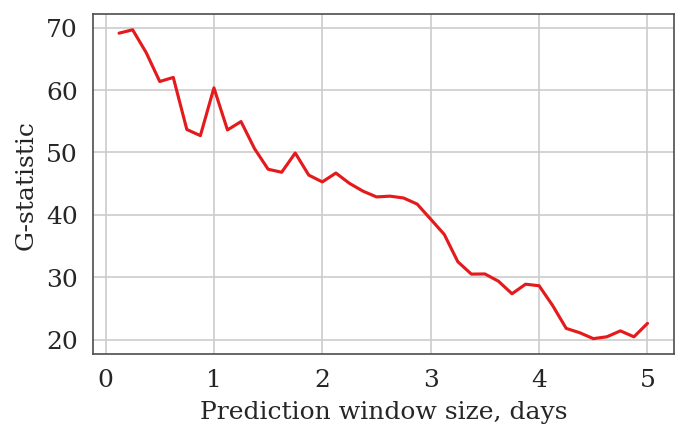

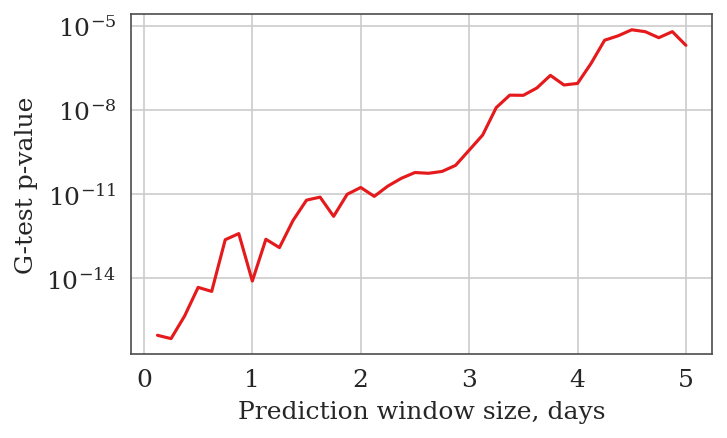

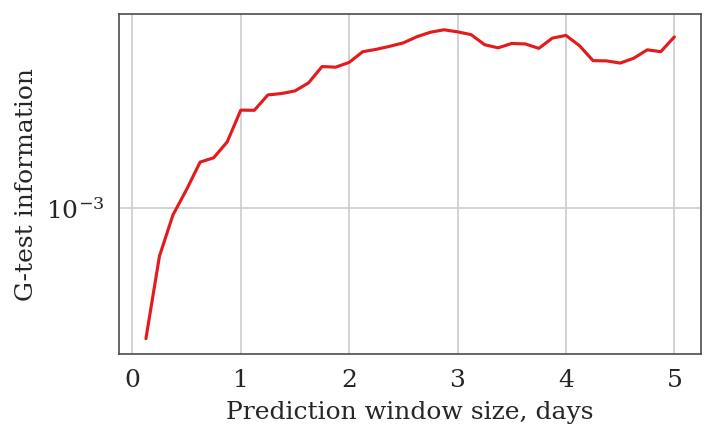

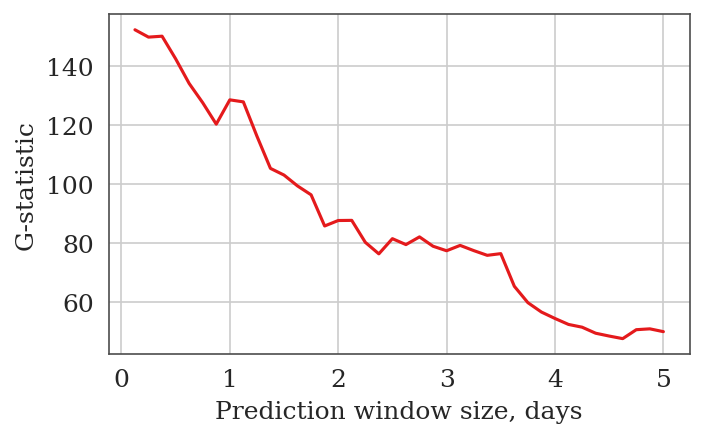

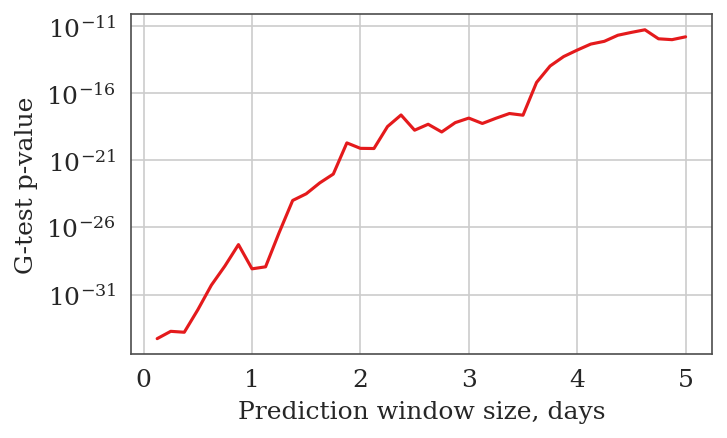

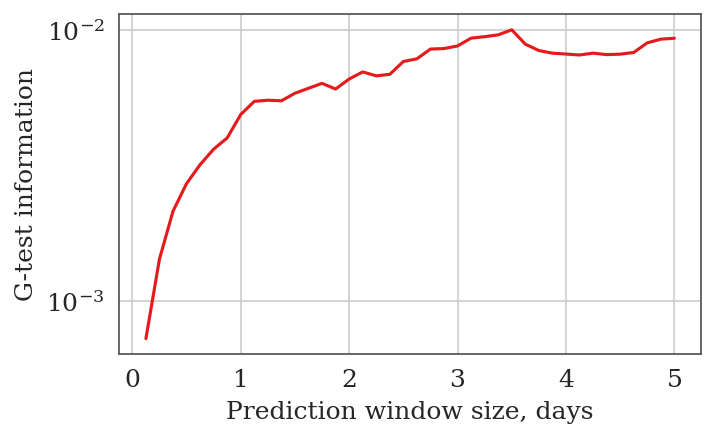

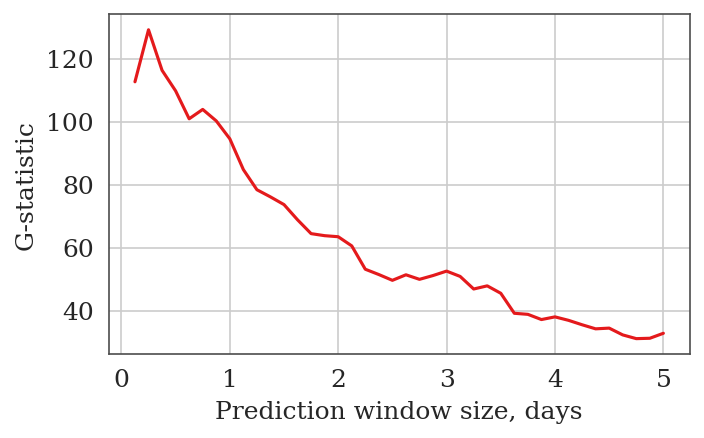

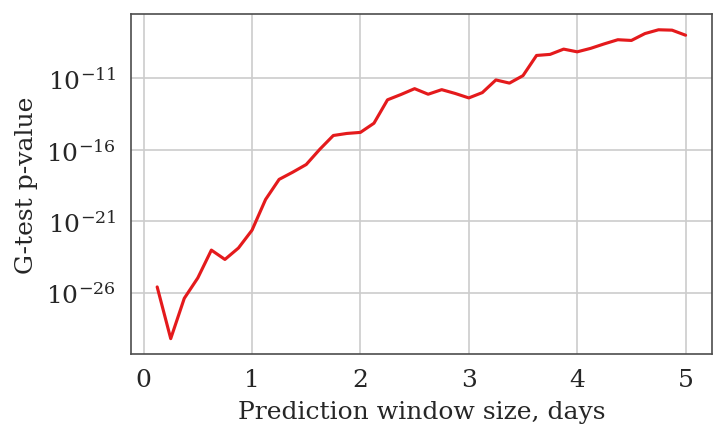

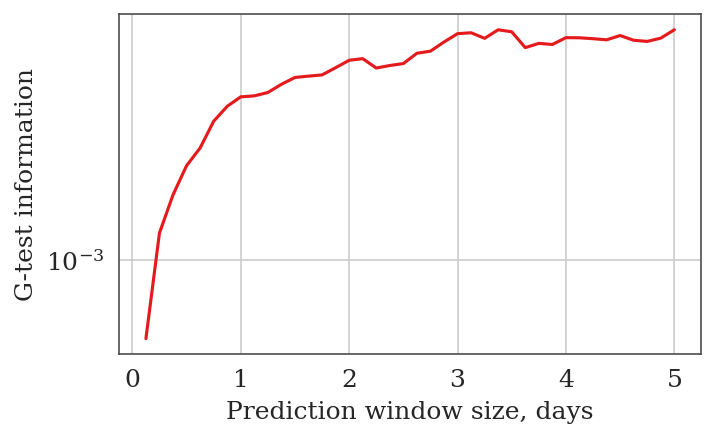

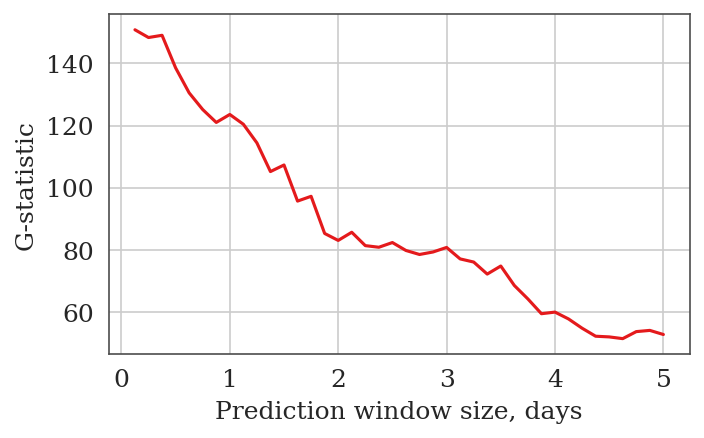

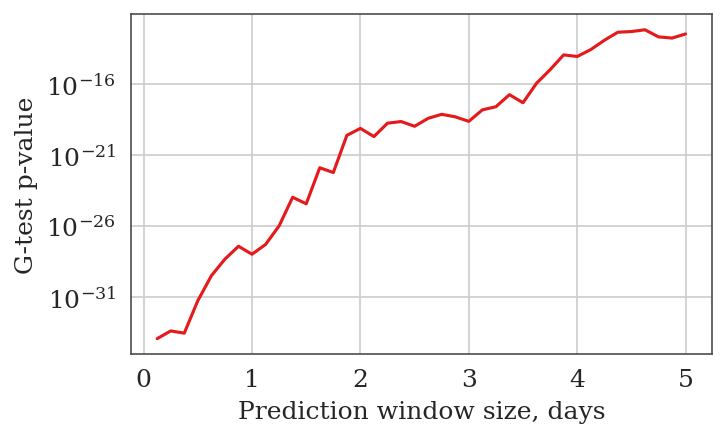

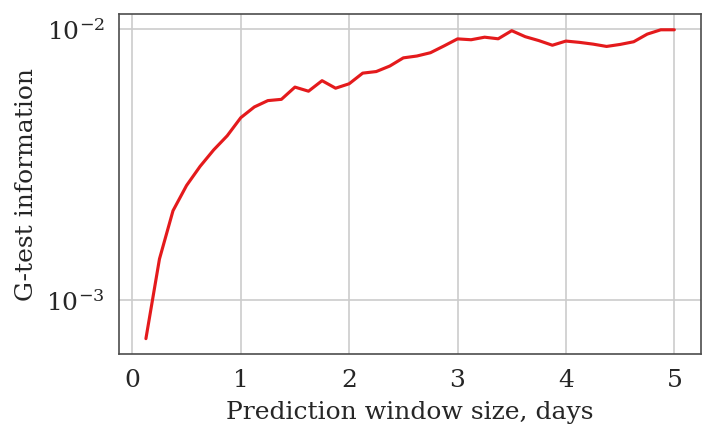

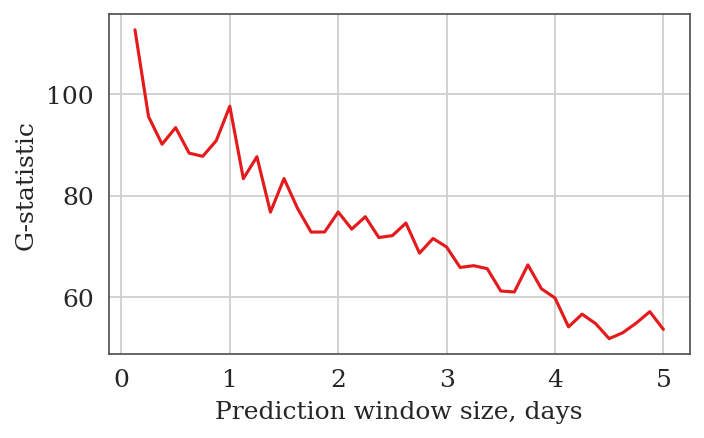

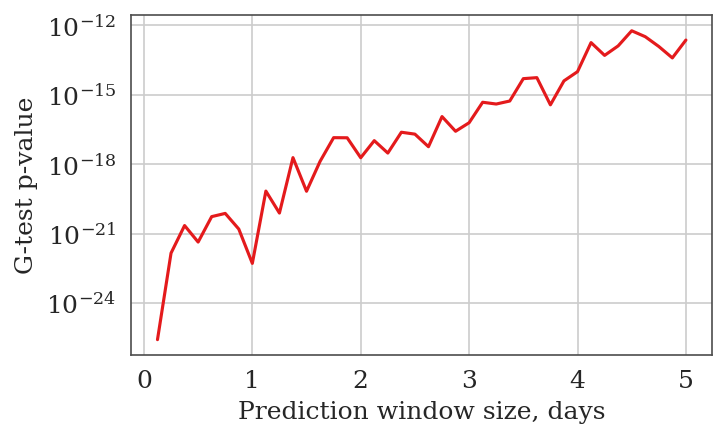

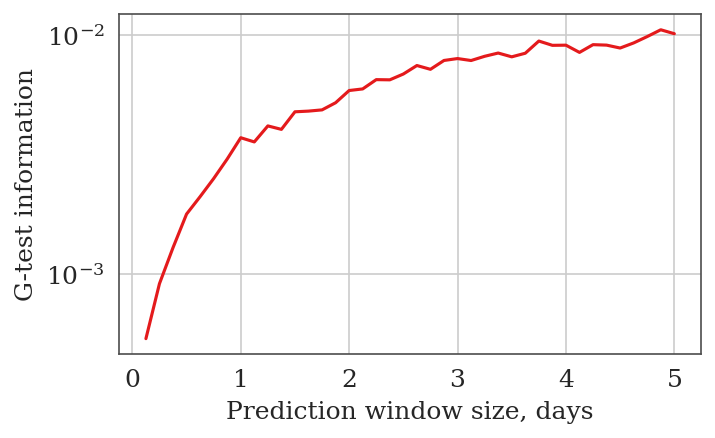

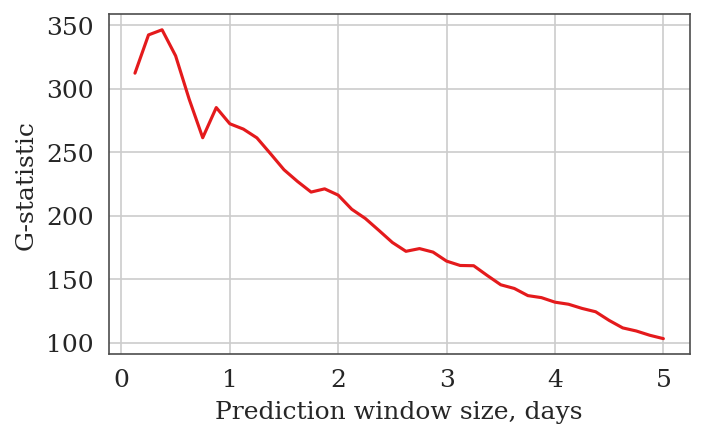

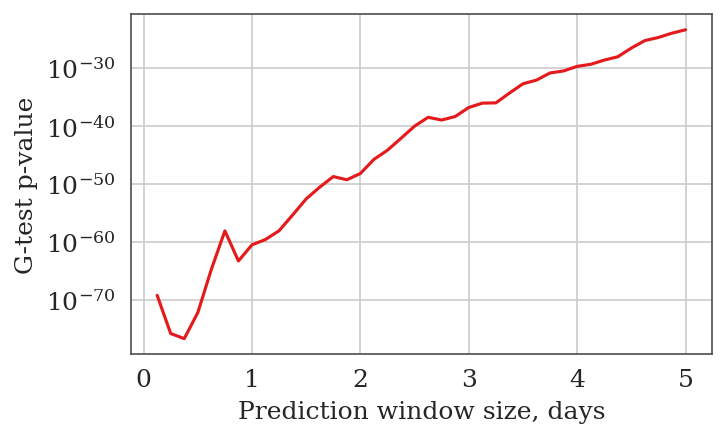

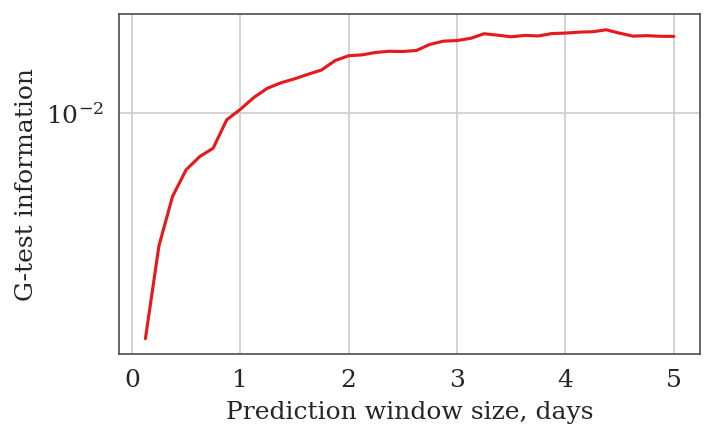

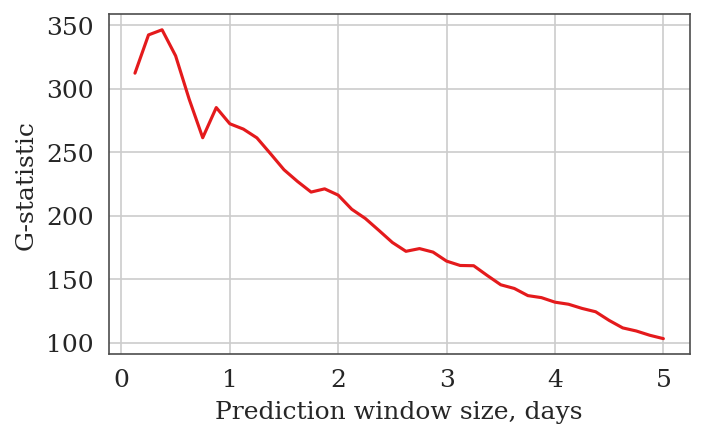

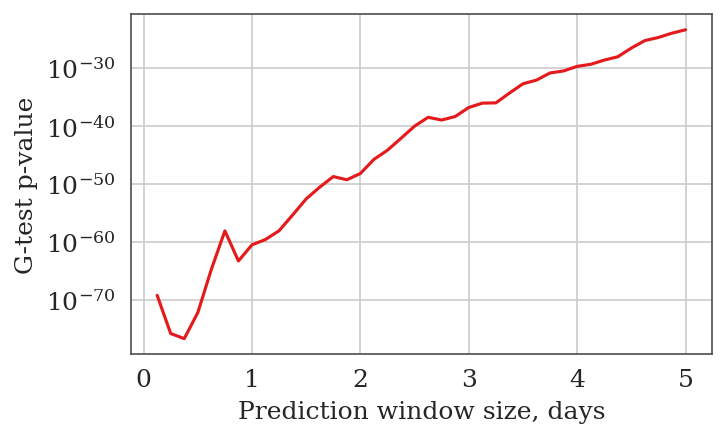

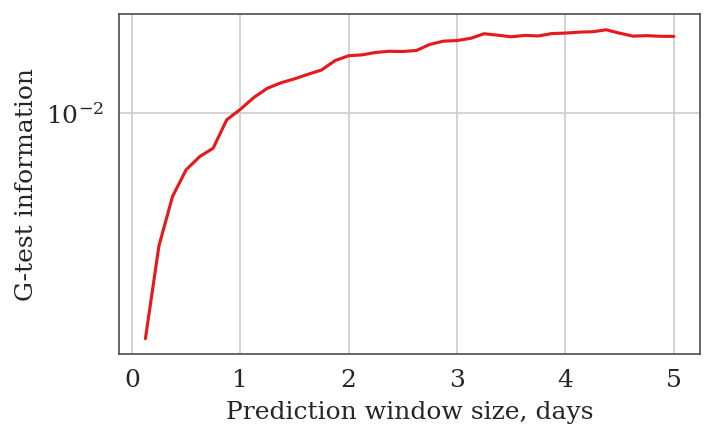

In [52]:
from metric_store import get_metric_names, load_metric, save_metric
from g_test_for_metrics.g_test_for_metrics import get_metric_indicators

data = np.load('../cyclones_events.npz')
for track_size in tqdm(config.g_test_options['track_sizes']):
    config.g_test_options['track_size'] = track_size
    cyclone_events = data[f'cyclone_events_{track_size}']
    cyclone_events_1d = cyclone_events.sum(axis=(0, 1))
    cyclone_events_1d.shape

    metric_names = list(get_metric_names(config, prefix = 'probability_for_metrics').keys())
    main_metric_names = ['degree_w', 'LCC_w', 'closeness_w', 'EVC_w', 'MSLP', 'MSLP_preproc', 'degree_0.9']
    selected_metric_names = []
    for metric_name in metric_names:
        for subname in main_metric_names:
            if metric_name.endswith(subname) and metric_name.find('diff_metrics') == -1:
                selected_metric_names += [metric_name]
                break
    
    for metric_name in tqdm(selected_metric_names):
        main_metric_name = metric_name[metric_name.find("/") + 1:]
        config.g_test_options['metric_name'] = main_metric_name
        metric_prob = load_metric(config, metric_name)

        """
        window_sizes = [1 * 8, 2 * 8, 3 * 8, 4 * 8, 5 * 8]
        thr_probs = np.geomspace(1e-5, 1e-2, 33)
        thrs = np.linspace(0, 25, 26)
        g_stat_full, p_vals_full, I_stat_full = traverse_g_stat(window_sizes, thr_probs, thrs, metric_prob, main_metric_name, cyclone_events_1d)
        export_g_stat(config, g_stat_full, p_vals_full, I_stat_full, thr_probs, thrs)
        """

        window_sizes = np.arange(1, 41) # 41
        thr_probs = np.geomspace(1e-5, 1e-2, 33) # 33
        thrs = np.linspace(0, 25, 26) # 26
        g_stat_full, p_vals_full, I_stat_full = traverse_g_stat(window_sizes, thr_probs, thrs, metric_prob, main_metric_name, cyclone_events_1d)
        window_sizes = np.array(window_sizes)
        g_stat_per_window, p_vals_per_window, I_stat_per_window = \
            compute_max_g_stat_per_window(window_sizes, thrs, thr_probs, g_stat_full, p_vals_full, I_stat_full)
        export_stat_per_window(config, window_sizes, g_stat_per_window, p_vals_per_window, I_stat_per_window)
        

In [196]:
window_size = window_sizes[10]
g_stats = g_stat_full[10]


thr_ids = np.unravel_index(np.nanargmax(g_stats), g_stats.shape)
thr, thr_prob = thrs[thr_ids[1]], thr_probs[thr_ids[0]]

predicted_events = get_metric_indicators(config, main_metric_name, metric_prob, thr=thr_prob)    
predicted_events_1d_sum = predicted_events.sum(axis=(0, 1))

predicted_events_1d = predicted_events_1d_sum > thr
contigency_table = estimate_prediction(predicted_events_1d, cyclone_events_1d, window_size)
g_stat, p_val = perform_g_test(contigency_table)
print(contigency_table, g_stat, p_val, window_size)

[[8114  268]
 [1094   84]] 37.06423292961395 1.1430120770948475e-09 11


In [172]:
window_sizes = np.arange(1, 41)
print(window_sizes)
thr_probs = np.geomspace(1e-5, 1e-1, 33)
thrs = np.linspace(0, 50, 51)
g_stat_full, p_vals_full = traverse_g_stat(window_sizes, thr_probs, thrs)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

8 1.0 0.004216965034285823 272.4594001918151 3.302954031061428e-61 0.010347869357835743
16 0.0 0.0022067340690845897 216.21700722929788 6.047594670566603e-49 0.01628630666083895
24 1.0 0.0014330125702369627 164.21852985549467 1.355260554569729e-37 0.018513926702987
32 0.0 0.0007498942093324559 131.8601078109358 1.605429993900513e-30 0.019721822885273077
40 0.0 0.0007498942093324559 103.12871217549936 3.1406625598333335e-24 0.019176034246095083


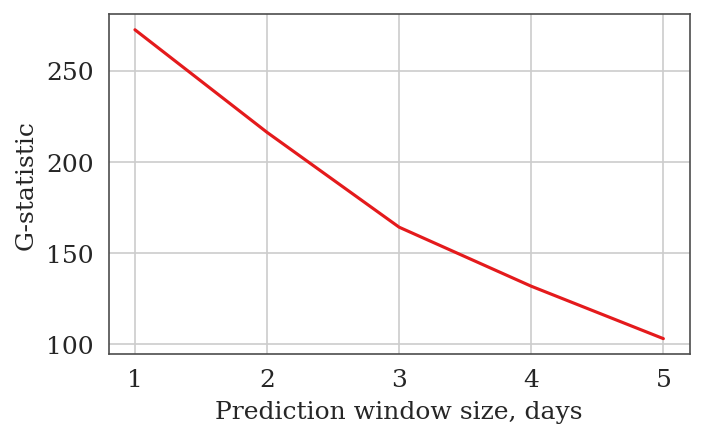

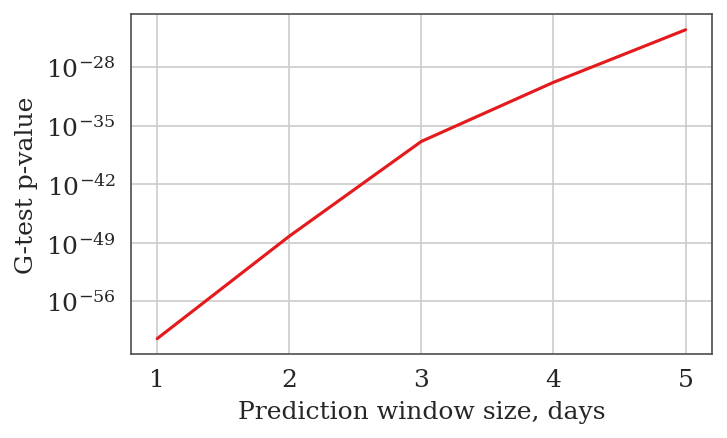

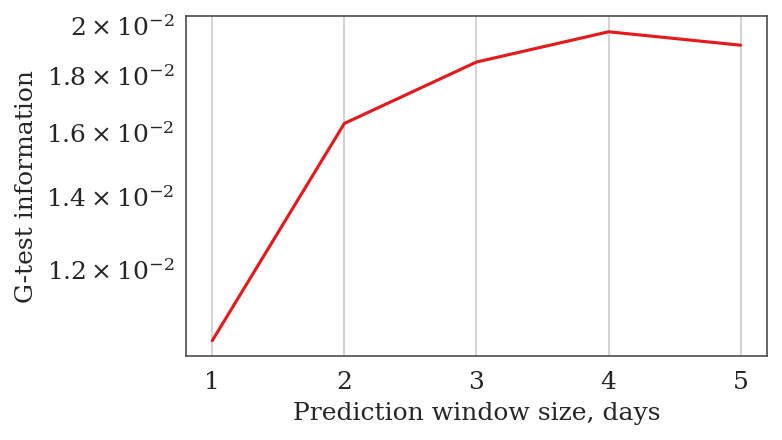

In [49]:
def compute_max_g_stat_per_window(window_sizes, thrs, thr_probs, g_stat_full, p_vals_full, I_stat_full):
    g_stat_per_window = []
    p_vals_per_window = []
    I_stat_per_window = []
    for i, window_size in enumerate(window_sizes):
        g_stats = np.array(g_stat_full[i])
        p_vals = np.array(p_vals_full[i])
        I_stats = np.array(I_stat_full[i])
        if np.all(np.isnan(g_stats)):
            g_stat_per_window += [np.nan]
            p_vals_per_window += [np.nan]
            I_stat_per_window += [np.nan]
        else:
            thr_ids = np.unravel_index(np.nanargmax(g_stats), g_stats.shape)
            thr, thr_prob = thrs[thr_ids[1]], thr_probs[thr_ids[0]]
            print(window_size, thr, thr_prob, g_stats[thr_ids[0]][thr_ids[1]], p_vals[thr_ids[0]][thr_ids[1]], I_stats[thr_ids[0]][thr_ids[1]])
            g_stat_per_window += [g_stats[thr_ids[0]][thr_ids[1]]]
            p_vals_per_window += [p_vals[thr_ids[0]][thr_ids[1]]]  
            I_stat_per_window += [I_stats[thr_ids[0]][thr_ids[1]]]
    return g_stat_per_window, p_vals_per_window, I_stat_per_window
    
def plot_stat_per_window(window_sizes, stat_per_window, ylabel, need_log):
    plt.figure(figsize=(5, 3), dpi=150)
    plt.plot(window_sizes / 8, stat_per_window)
    plt.xlabel('Prediction window size, days')
    plt.ylabel(ylabel)
    if need_log:
        plt.yscale('log')
    
def export_stat_per_window(config, window_sizes, g_stat_per_window, p_vals_per_window, I_stat_per_window):
    path_name = config.work_dir
    path_name /= f"results_{config.prefix_for_preproc_data}_{config.prefix_for_corr}"
    path_name /= "cyclone_metric_relation"
    path_name /= f"track_size_{config.g_test_options['track_size']}"
    path_name /= config.g_test_options['metric_name']
    path_name.mkdir(parents=True, exist_ok=True)

    plot_stat_per_window(window_sizes, g_stat_per_window, ylabel='G-statistic', need_log=False)
    file_name = path_name / f"g-stat_per_prediction_window_size.png"
    plt.savefig(file_name, bbox_inches='tight')

    plot_stat_per_window(window_sizes, p_vals_per_window, ylabel='G-test p-value', need_log=True)
    file_name = path_name / f"p-value_per_prediction_window_size.png"
    plt.savefig(file_name, bbox_inches='tight')

    plot_stat_per_window(window_sizes, I_stat_per_window, ylabel='G-test information', need_log=True)
    file_name = path_name / f"Information_per_prediction_window_size.png"
    plt.savefig(file_name, bbox_inches='tight')

config.g_test_options['metric_name'] = main_metric_name
window_sizes = np.array(window_sizes)
g_stat_per_window, p_vals_per_window, I_stat_per_window = \
    compute_max_g_stat_per_window(window_sizes, thrs, thr_probs, g_stat_full, p_vals_full, I_stat_full)
export_stat_per_window(config, window_sizes, g_stat_per_window, p_vals_per_window, I_stat_per_window)

In [32]:
window_sizes

array([ 8, 16, 24, 32, 40])

In [ ]:
def plot_g_stat(g_stats, thr_probs, thrs, clim, title_name, clim_logspace):
    from matplotlib import colors
    fig = plt.figure(figsize=(10, 3), dpi=150)
    if clim_logspace:
        norm = colors.LogNorm()
    else:
        norm = None
    im = plt.imshow(g_stats, aspect='auto', clim=clim, cmap='viridis', norm=norm)
    xticks_ids = np.arange(0, len(thrs), 5)
    ax = plt.gca()
    ax.set_xticks(xticks_ids)
    ax.set_xticklabels(map(lambda x: "{:0.0f}".format(x), thrs[xticks_ids]))
    thr_probs = np.array(thr_probs)
    yticks_ids = np.arange(0, len(thr_probs), 4)
    ax.set_yticks(yticks_ids)
    ax.set_yticklabels(map(lambda x: "{:0.1g}".format(x), thr_probs[yticks_ids]))
    plt.colorbar()
    plt.grid(False)
    plt.title(title_name)
    plt.xlabel('Threshold: number of predicted pixels on frame')
    plt.ylabel('Threshold: CCDF probability')
    return fig

def export_g_stat(config, g_stat_full, p_vals_full, I_stat_full, thr_probs, thrs):
    path_name = config.work_dir
    path_name /= f"results_{config.prefix_for_preproc_data}_{config.prefix_for_corr}"
    path_name /= "cyclone_metric_relation"
    path_name /= f"track_size_{config.g_test_options['track_size']}"
    path_name /= f"{config.g_test_options['metric_name']}"
    path_name.mkdir(parents=True, exist_ok=True)

    for i, window_size in tqdm(enumerate(window_sizes)):
        g_stats = g_stat_full[i]
        fig = plot_g_stat(g_stats, thr_probs, thrs, clim = [0, 50], title_name = f"G-stat. Window block size: {window_size / 8} days", clim_logspace=False)
        file_name = path_name / f"g-stat_window_size_{window_size / 8}.png"
        plt.savefig(file_name, bbox_inches='tight')
        plt.close(fig)

        p_vals = p_vals_full[i]
        fig = plot_g_stat(p_vals, thr_probs, thrs, clim = [1e-9, 1], title_name = f"P-value. Window block size: {window_size / 8} days", clim_logspace=True)
        file_name = path_name / f"p-value_window_size_{window_size / 8}.png"
        plt.savefig(file_name, bbox_inches='tight')
        plt.close(fig)

        I_stats = I_stat_full[i]
        fig = plot_g_stat(I_stats, thr_probs, thrs, clim=[1e-4, 1e-2], title_name = f"Information. Window block size: {window_size / 8} days", clim_logspace=True)
        file_name = path_name / f"Information_window_size_{window_size / 8}.png"
        plt.savefig(file_name, bbox_inches='tight')
        plt.close(fig)


In [ ]:
def plot_g_stat(g_stats, thr_probs, thrs, clim, title_name, clim_logspace):
    from matplotlib import colors
    fig = plt.figure(figsize=(10, 3), dpi=150)
    if clim_logspace:
        norm = colors.LogNorm()
    else:
        norm = None
    im = plt.imshow(g_stats, aspect='auto', clim=clim, cmap='viridis', norm=norm)
    xticks_ids = np.arange(0, len(thrs), 5)
    ax = plt.gca()
    ax.set_xticks(xticks_ids)
    ax.set_xticklabels(map(lambda x: "{:0.0f}".format(x), thrs[xticks_ids]))
    thr_probs = np.array(thr_probs)
    yticks_ids = np.arange(0, len(thr_probs), 4)
    ax.set_yticks(yticks_ids)
    ax.set_yticklabels(map(lambda x: "{:0.1g}".format(x), thr_probs[yticks_ids]))
    plt.colorbar()
    plt.grid(False)
    plt.title(title_name)
    plt.xlabel('Threshold: number of predicted pixels on frame')
    plt.ylabel('Threshold: CCDF probability')
    return fig

def export_g_stat(config, g_stat_full, p_vals_full, I_stat_full, thr_probs, thrs):
    path_name = config.work_dir
    path_name /= f"results_{config.prefix_for_preproc_data}_{config.prefix_for_corr}"
    path_name /= "cyclone_metric_relation"
    path_name /= f"track_size_{config.g_test_options['track_size']}"
    path_name /= f"{config.g_test_options['metric_name']}"
    path_name.mkdir(parents=True, exist_ok=True)

    for i, window_size in tqdm(enumerate(window_sizes)):
        g_stats = g_stat_full[i]
        fig = plot_g_stat(g_stats, thr_probs, thrs, clim = [0, 50], title_name = f"G-stat. Window block size: {window_size / 8} days", clim_logspace=False)
        file_name = path_name / f"g-stat_window_size_{window_size / 8}.png"
        plt.savefig(file_name, bbox_inches='tight')
        plt.close(fig)

        p_vals = p_vals_full[i]
        fig = plot_g_stat(p_vals, thr_probs, thrs, clim = [1e-9, 1], title_name = f"P-value. Window block size: {window_size / 8} days", clim_logspace=True)
        file_name = path_name / f"p-value_window_size_{window_size / 8}.png"
        plt.savefig(file_name, bbox_inches='tight')
        plt.close(fig)

        I_stats = I_stat_full[i]
        fig = plot_g_stat(I_stats, thr_probs, thrs, clim=[1e-4, 1e-2], title_name = f"Information. Window block size: {window_size / 8} days", clim_logspace=True)
        file_name = path_name / f"Information_window_size_{window_size / 8}.png"
        plt.savefig(file_name, bbox_inches='tight')
        plt.close(fig)


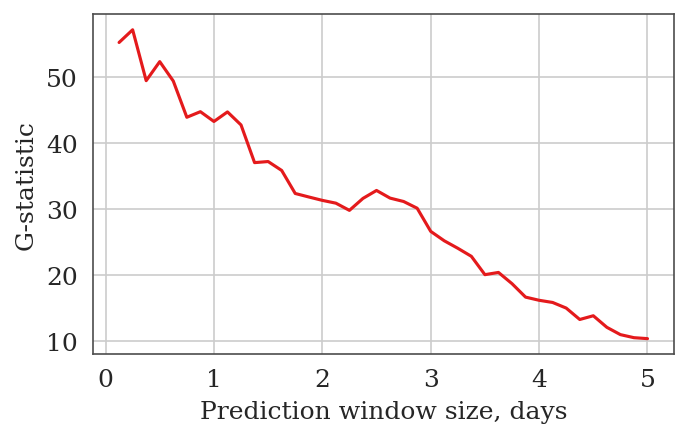

In [191]:
plt.figure(figsize=(5, 3), dpi=150)
plt.plot(window_sizes / 8, g_stat_per_window)
plt.xlabel('Prediction window size, days')
plt.ylabel('G-statistic')
file_name = path_name / f"g-stat_per_prediction_window_size.png"
plt.savefig(file_name, bbox_inches='tight')

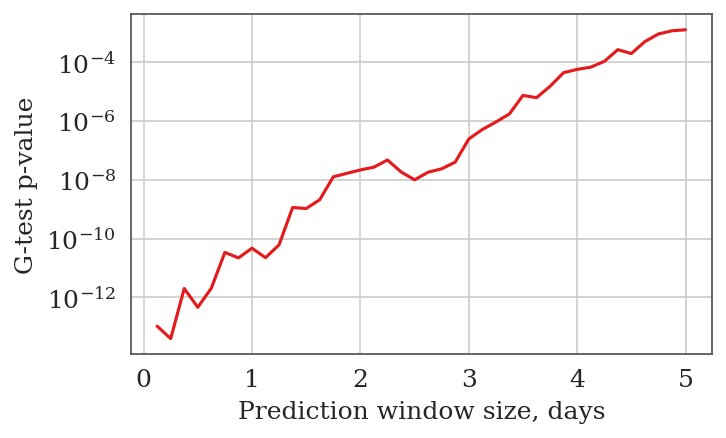

In [193]:
plt.figure(figsize=(5, 3), dpi=150)
plt.plot(window_sizes / 8, p_vals_per_window)
plt.xlabel('Prediction window size, days')
plt.ylabel('G-test p-value')
plt.yscale('log')
file_name = path_name / f"p-value_per_prediction_window_size.png"
plt.savefig(file_name, bbox_inches='tight')